In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import re
import pickle as pk

from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from transformers import AutoTokenizer, AutoModel#RobertaTokenizer, RobertaModel
from scipy.spatial.distance import cdist

from sklearn.utils import shuffle

from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib as mpl

np.random.seed(42)
random.seed(42)

In [2]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [3]:
DEVICE = "cuda:0"
TEST_SPAN = 500, 1000

### Loading files and model

In [4]:
def make_cls():
    classifier = LogisticRegression()
    return classifier

In [5]:
stackexchange_path_gpt3 = "../data/davinci_generation/gpt3_davinci_003_300_len_stackexchange.jsonl"
reddit_path_gpt3 = "../data/davinci_generation/gpt3_davinci_003_300_len_reddit.jsonl"
wiki_path_gpt3 = "../data/davinci_generation/gpt3_davinci_003_300_len_wiki.jsonl"

In [6]:
df_gpt3_w = pd.read_json(wiki_path_gpt3, lines=True)[:1500]
df_gpt3_r = pd.read_json(reddit_path_gpt3, lines=True)[:1500]
df_gpt3_s = pd.read_json(stackexchange_path_gpt3, lines=True)[:1500]

In [7]:
model_path = 'roberta-base'#'bert-base-uncased'
tokenizer_path = model_path

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModel.from_pretrained(model_path, output_hidden_states=True)
model = model.to(DEVICE)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Extracting embeddings

In [8]:
def text_preprocessing(text):
    
    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [9]:
def get_mean(df, key='text', real=True, verbose=True):
    dims, lens = [], []
    if verbose:
        iterable = tqdm(df[key])
    else:
        iterable = df[key]
    for ss in iterable:
        if not real:
            sss = ss[0]
        else:
            sss = ss
        sss = text_preprocessing(sss)

        inputs = tokenizer(sss, truncation=True, max_length=512, return_tensors="pt")
        inputs = inputs.to(DEVICE)
        with torch.no_grad():
            outp = model(**inputs)       

        dims.append(np.mean(outp[0].cpu().numpy()[0, :], axis=0))
        lens.append(outp[0].shape[1])
    
    return np.array(dims), lens

In [10]:
cls_gpt_w_3, lens_gpt_w_3 = get_mean(df_gpt3_w, 'gen_completion', real=True)
cls_human_w_3, lens_human_w_3 = get_mean(df_gpt3_w, 'gold_completion', real=True)

cls_gpt_r_3, lens_gpt_r_3 = get_mean(df_gpt3_r, 'gen_completion', real=True)
cls_human_r_3, lens_human_r_3 = get_mean(df_gpt3_r, 'gold_completion', real=True)

cls_gpt_s_3, lens_gpt_s_3 = get_mean(df_gpt3_s, 'gen_completion', real=True)
cls_human_s_3, lens_human_s_3 = get_mean(df_gpt3_s, 'gold_completion', real=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:19<00:00, 76.09it/s]


In [11]:
X_train_sets = {"gpt_wikipedia": (cls_gpt_w_3, cls_human_w_3),
                "gpt_reddit": (cls_gpt_r_3, cls_human_r_3), 
                "gpt_stackexchange": (cls_gpt_s_3, cls_human_s_3)}

X_test_sets = {}
for key in X_train_sets.keys():
    X_test_sets[key] = (X_train_sets[key][0][TEST_SPAN[0]:TEST_SPAN[1]], 
                        X_train_sets[key][1][TEST_SPAN[0]:TEST_SPAN[1]])

## Finding the components to remove

In [12]:
def exclude_dims(embs, dims_to_exclude):
    # Excluding some dimensions from embeddings array
    mask = [True] * embs.shape[1]
    for dim in dims_to_exclude:
        mask[dim] = False
    result_embs = np.transpose(embs)
    result_embs = result_embs[mask]
    result_embs = np.transpose(result_embs)
    return result_embs

In [13]:
models_for_greedy_search = ["gpt_reddit", "gpt_wikipedia"]#["gpt_wikipedia", "gpt_reddit"]#

In [14]:
removed_dims_and_acc = dict() # For greedy algorithm results
dims_to_exclude = []

current_X_train = X_train_sets[models_for_greedy_search[0]]
current_X_test  = X_test_sets[models_for_greedy_search[0]]
current_X_ood   = X_train_sets[models_for_greedy_search[1]]

for _ in tqdm(range(current_X_train[0].shape[1] - 1)):
    # We are going through components-candidates for removal and checking the results
    ood_quality_by_coord = dict()
    test_quality_by_coord = dict()
    dims_to_exclude_set = set(dims_to_exclude)
    for coord in range(current_X_train[0].shape[1]):
        if coord not in dims_to_exclude_set:
            
            X_train = exclude_dims(np.vstack([current_X_train[0][:TEST_SPAN[0]], 
                                              current_X_train[1][:TEST_SPAN[0]]]), dims_to_exclude + [coord])
            TRAIN_SIZE = current_X_train[0][:TEST_SPAN[0]].shape[0]
            y_train = np.hstack([np.zeros(TRAIN_SIZE), np.ones(TRAIN_SIZE)])

            X_test = exclude_dims(np.vstack([current_X_test[0], 
                                             current_X_test[1]]), dims_to_exclude + [coord])
            y_test = np.hstack([np.zeros(len(current_X_test[0])), 
                                np.ones(len(current_X_test[1]))])
            
            X_ood  = exclude_dims(np.vstack([current_X_ood[0], 
                                             current_X_ood[1]]), dims_to_exclude + [coord])
            y_ood  = np.hstack([np.zeros(len(current_X_ood[0])), 
                                np.ones(len(current_X_ood[1]))])

            lrr = LogisticRegression(max_iter=100)
            lrr.fit(X_train, y_train)

            ood_score = lrr.score(X_ood, y_ood)
            test_score = lrr.score(X_test, y_test)
            
            #We check how removing the coordinate influenced the transferability
            ood_quality_by_coord[ood_score] = coord
            test_quality_by_coord[test_score] = coord
    best_ood_acc = max(ood_quality_by_coord.keys())
    best_coord = ood_quality_by_coord[best_ood_acc]
    best_test_acc = -1
    for key in test_quality_by_coord:
        if test_quality_by_coord[key] == best_coord:
            best_test_acc = key
    dims_to_exclude.append(best_coord)
    removed_dims_and_acc[tuple(dims_to_exclude)] = (best_ood_acc, best_test_acc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 767/767 [4:40:57<00:00, 21.98s/it]


### Accuracy depending on the amount of removed components

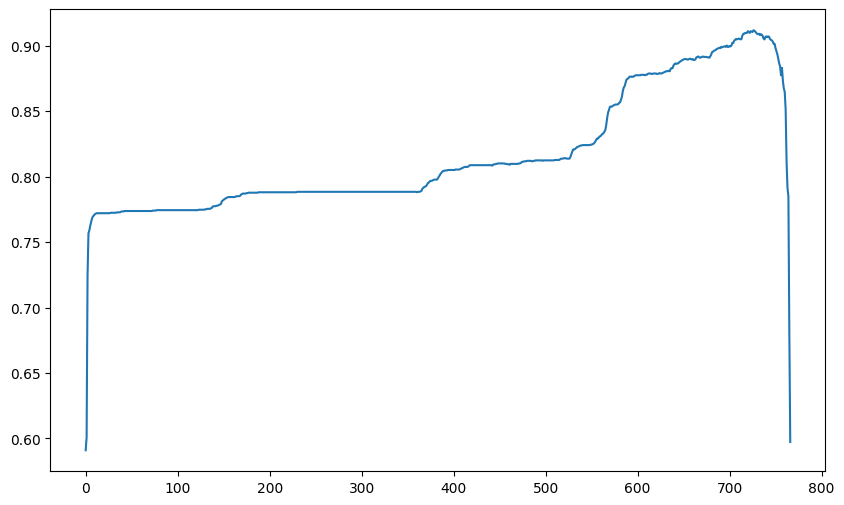

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(list(map(lambda x:x[0], removed_dims_and_acc.values())))
plt.show()

### Results to be used in other scripts

In [16]:
argmax_value = np.argmax(list(map(lambda x:x[0], removed_dims_and_acc.values())))
print(list(removed_dims_and_acc.keys())[argmax_value]), len(list(removed_dims_and_acc.keys())[argmax_value])

(330, 551, 77, 217, 664, 61, 286, 751, 709, 759, 736, 766, 577, 744, 746, 717, 762, 767, 742, 725, 715, 708, 757, 726, 722, 721, 723, 692, 761, 755, 711, 713, 760, 724, 620, 719, 681, 730, 758, 686, 728, 718, 640, 700, 710, 671, 669, 697, 673, 704, 676, 659, 657, 668, 654, 660, 677, 658, 648, 642, 629, 644, 680, 602, 597, 649, 555, 581, 579, 605, 628, 691, 729, 274, 651, 609, 763, 515, 748, 703, 632, 685, 675, 626, 650, 423, 593, 584, 571, 537, 547, 590, 494, 543, 566, 531, 535, 525, 522, 493, 501, 466, 500, 509, 458, 391, 360, 444, 619, 653, 621, 524, 565, 474, 462, 471, 487, 416, 354, 480, 583, 510, 553, 484, 706, 690, 630, 665, 638, 687, 508, 737, 293, 636, 635, 616, 282, 424, 75, 492, 754, 753, 139, 738, 702, 18, 587, 534, 102, 478, 328, 696, 311, 734, 740, 633, 743, 634, 607, 603, 682, 670, 645, 20, 594, 698, 612, 548, 149, 223, 701, 707, 739, 688, 712, 683, 613, 239, 705, 639, 601, 576, 747, 610, 575, 631, 618, 591, 59, 556, 507, 578, 516, 497, 532, 552, 695, 646, 563, 558, 514, 

(None, 727)

# Put together dimensions to remove

from "gpt_reddit" -> "gpt_wikipedia" and "gpt_wikipedia" -> "gpt_reddit" versions of this script

In [19]:
to_remove_1 = (731, 624, 131, 219, 330, 749, 652, 764, 672, 685, 548, 541, 286, 528, 490, 634, 737, 538, 4, 686, 240, 368, 598, 559, 647, 730, 102, 397, 384, 269, 575, 320, 193, 394, 167, 278, 655, 484, 543, 229, 429, 370, 713, 288, 283, 703, 693, 303, 525, 313, 585, 149, 331, 675, 280, 366, 168, 558, 645, 166, 588, 446, 519, 467, 578, 29, 78, 75, 699, 47, 416, 465, 198, 683, 106, 491, 247, 342, 74, 687, 73, 225, 767, 766, 761, 759, 760, 755, 763, 754, 218, 747, 757, 744, 758, 742, 736, 746, 723, 719, 720, 710, 512, 273, 185, 365, 432, 355, 443, 623, 226, 694, 422, 762, 428, 660, 705, 659, 306, 608, 485, 130, 728, 407, 151, 176, 425, 740, 738, 665, 651, 497, 690, 531, 539, 221, 729, 726, 743, 90, 343, 510, 516, 327, 722, 62, 680, 668, 566, 622, 734, 712, 709, 350, 717, 745, 700, 697, 706, 704, 733, 718, 406, 333, 311, 613, 701, 557, 627, 676, 498, 328, 357, 572, 348, 619, 133, 644, 629, 630, 725, 696, 756, 213, 48, 653, 502, 667, 640, 295, 671, 663, 452, 435, 249, 603, 487, 708, 695, 681, 692, 716, 724, 554, 110, 707, 677, 688, 684, 391, 657, 642, 639, 638, 632, 636, 631, 621, 618, 542, 41, 404, 84, 727, 589, 282, 312, 511, 363, 517, 412, 601, 656, 635, 607, 244, 590, 111, 8, 351, 458, 615, 356, 421, 258, 401, 385, 584, 569, 620, 610, 576, 418, 513, 587, 593, 591, 555, 583, 579, 609, 654, 563, 545, 526, 504, 669, 552, 527, 520, 514, 522, 508, 509, 501, 533, 499, 494, 482, 479, 457, 411, 447, 396, 388, 390, 415, 488, 592, 641, 360, 395, 30, 377, 532, 426, 302, 617, 537, 544, 547, 299, 658, 515, 753, 437, 571, 567, 461, 637, 478, 449, 442, 445, 380, 372, 456, 431, 423, 440, 358, 500, 252, 298, 277, 344, 284, 556, 175, 470, 466, 507, 459, 460, 383, 408, 305, 420, 405, 336, 410, 163, 352, 334, 322, 290, 323, 480, 392, 332, 338, 308, 646, 628, 565, 469, 321, 455, 346, 393, 464, 118, 698, 337, 650, 316, 255, 462, 270, 493, 56, 506, 450, 463, 341, 430, 414, 424, 389, 228, 375, 382, 354, 386, 362, 319, 381, 263, 349, 371, 691, 602, 304, 279, 274, 289, 523, 616, 268, 246, 271, 266, 477, 347, 281, 242, 448, 227, 224, 220, 216, 207, 188, 315, 374, 260, 564, 369, 206, 186, 208, 170, 237, 179, 171, 169, 162, 160, 158, 317, 144, 146, 132, 103, 95, 81, 68, 113, 152, 138, 96, 89, 143, 121, 117, 257, 181, 253, 23, 153, 294, 192, 489, 230, 99, 39, 44, 36, 139, 33, 210, 92, 150, 24, 52, 27, 12, 18, 245, 250, 134, 200, 13, 196, 104, 293, 481, 711, 177, 184, 142, 367, 581, 297, 441, 172, 215, 98, 254, 88, 582, 140, 568, 741, 599, 222, 209, 53, 173, 417, 7, 3, 45, 136, 25, 148, 223, 476, 444, 495, 472, 427, 307, 505, 296, 127, 65, 147, 35, 1, 14, 72, 492, 0, 402, 70, 60, 400, 50, 471, 164, 105, 120, 156, 605, 66, 109, 673, 57, 190, 69, 141, 702, 51, 234, 530, 272, 256, 119, 6, 614, 86, 194, 626, 267, 180, 625, 101, 49, 145, 474, 275, 318, 241, 54, 108, 239, 42, 10, 191, 236, 135, 248, 37, 387, 214, 204, 549, 483, 715, 187, 182, 361, 329, 211, 43, 20, 434, 562, 128, 560, 238, 87, 26, 594, 574, 231, 94, 648, 114, 276, 751, 17, 199, 129, 503, 439, 301, 633, 643, 335, 91, 536, 529, 419, 314, 197, 22, 475, 32, 577, 612, 11, 714, 604, 40, 340, 399, 682, 9, 649, 661, 262, 524, 251, 58, 137, 178, 107, 413, 468, 16, 80, 19, 285, 34, 486, 195, 436, 112, 64, 122, 183, 59, 534, 438, 546, 561, 174, 535, 597, 721, 595, 670, 433, 165, 46, 243, 124, 63, 689, 83, 31, 212, 154, 521, 205, 310, 292, 116, 732, 403, 21, 739, 553, 28, 126, 123, 600, 77, 551, 496, 664, 570, 235, 217, 61, 233, 735, 674, 376, 359, 364, 662, 93, 159, 586, 748, 79, 666, 451, 606, 345, 580, 76, 379, 339, 155, 201, 100, 115, 125, 300, 752, 518, 540, 261, 409, 750, 373, 325)
to_remove_2 = (330, 551, 77, 217, 664, 61, 286, 751, 709, 759, 736, 766, 577, 744, 746, 717, 762, 767, 742, 725, 715, 708, 757, 726, 722, 721, 723, 692, 761, 755, 711, 713, 760, 724, 620, 719, 681, 730, 758, 686, 728, 718, 640, 700, 710, 671, 669, 697, 673, 704, 676, 659, 657, 668, 654, 660, 677, 658, 648, 642, 629, 644, 680, 602, 597, 649, 555, 581, 579, 605, 628, 691, 729, 274, 651, 609, 763, 515, 748, 703, 632, 685, 675, 626, 650, 423, 593, 584, 571, 537, 547, 590, 494, 543, 566, 531, 535, 525, 522, 493, 501, 466, 500, 509, 458, 391, 360, 444, 619, 653, 621, 524, 565, 474, 462, 471, 487, 416, 354, 480, 583, 510, 553, 484, 706, 690, 630, 665, 638, 687, 508, 737, 293, 636, 635, 616, 282, 424, 75, 492, 754, 753, 139, 738, 702, 18, 587, 534, 102, 478, 328, 696, 311, 734, 740, 633, 743, 634, 607, 603, 682, 670, 645, 20, 594, 698, 612, 548, 149, 223, 701, 707, 739, 688, 712, 683, 613, 239, 705, 639, 601, 576, 747, 610, 575, 631, 618, 591, 59, 556, 507, 578, 516, 497, 532, 552, 695, 646, 563, 558, 514, 505, 506, 495, 477, 469, 482, 479, 512, 489, 481, 622, 475, 437, 436, 513, 428, 435, 455, 476, 413, 407, 405, 371, 355, 352, 614, 463, 457, 637, 549, 483, 459, 485, 600, 464, 418, 395, 383, 382, 401, 336, 370, 567, 490, 441, 440, 340, 322, 367, 338, 426, 362, 486, 598, 528, 572, 447, 533, 465, 562, 402, 389, 415, 412, 332, 460, 425, 559, 381, 384, 313, 427, 305, 377, 358, 341, 304, 298, 285, 288, 337, 300, 504, 385, 433, 394, 369, 429, 329, 303, 320, 267, 281, 307, 315, 314, 271, 296, 302, 272, 270, 237, 249, 230, 284, 253, 269, 250, 146, 244, 363, 260, 211, 246, 204, 190, 241, 196, 187, 186, 181, 173, 266, 294, 221, 309, 152, 273, 346, 145, 177, 431, 275, 291, 133, 256, 184, 129, 126, 160, 110, 292, 400, 290, 456, 161, 182, 245, 254, 143, 135, 134, 114, 101, 125, 96, 92, 118, 220, 452, 215, 517, 434, 625, 541, 349, 171, 16, 585, 545, 379, 716, 661, 347, 672, 540, 745, 546, 520, 420, 268, 240, 365, 201, 251, 95, 488, 699, 117, 470, 523, 521, 574, 503, 589, 518, 334, 392, 623, 582, 544, 491, 310, 316, 561, 526, 421, 689, 86, 408, 170, 108, 530, 454, 732, 406, 450, 357, 399, 560, 372, 342, 243, 321, 234, 156, 168, 387, 72, 164, 308, 89, 66, 109, 56, 53, 32, 140, 104, 88, 107, 361, 36, 374, 378, 257, 615, 203, 448, 80, 277, 130, 54, 48, 6, 113, 212, 43, 229, 432, 376, 34, 289, 568, 442, 319, 345, 228, 210, 323, 112, 502, 41, 73, 200, 188, 172, 121, 366, 499, 207, 174, 81, 242, 592, 396, 299, 132, 154, 119, 49, 127, 65, 70, 98, 35, 343, 52, 2, 224, 326, 375, 335, 312, 162, 123, 0, 120, 403, 356, 147, 83, 197, 128, 569, 138, 287, 262, 208, 529, 252, 191, 137, 141, 445, 388, 247, 765, 276, 26, 461, 255, 368, 417, 467, 393, 339, 542, 279, 105, 238, 227, 693, 222, 226, 9, 136, 7, 99, 667, 438, 414, 663, 206, 656, 627, 348, 258, 116, 364, 63, 106, 90, 194, 131, 219, 731, 749, 608, 214, 611, 380, 306, 536, 248, 44, 410, 641, 411, 317, 764, 40, 409, 155, 22, 259, 498, 331, 45, 51, 64, 192, 153, 350, 93, 280, 344, 318, 261, 37, 144, 225, 617, 47, 94, 325, 198, 216, 295, 643, 14, 39, 158, 327, 163, 741, 550, 150, 25, 19, 727, 557, 12, 178, 301, 595, 76, 50, 31, 539, 236, 57, 263, 1, 735, 148, 84, 100, 62, 599, 175, 449, 756, 439, 166, 386, 209, 652, 404, 11, 351, 179, 151, 69, 185, 167, 283, 142, 714, 79, 183, 74, 3, 27, 42, 103, 684, 624, 538, 233, 33, 604, 554, 666, 199, 68, 180, 511, 647, 213, 674, 24, 157, 586, 430, 91, 422, 8, 46, 333, 111, 189, 231, 87, 419, 218, 468, 202, 519, 30, 580, 38, 29, 720, 750, 176, 564, 390, 278, 58, 588, 662, 359, 169, 443, 694, 165, 324, 472, 451, 297, 28, 78, 527, 205, 60)

to_remove = set(to_remove_1).intersection(set(to_remove_2))
print(to_remove)
print(len(to_remove))

{0, 1, 3, 6, 7, 8, 9, 11, 12, 14, 16, 18, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 68, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 116, 117, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 194, 196, 197, 198, 199, 200, 201, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 233, 234, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 